# Ridings

In [1]:
%matplotlib inline
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from IPython.display import display
from elections import models as election_models
from parliaments import models as parliament_models
from proceedings import models as proceeding_models
from django_extensions.db.fields.json import JSONDict
from collections import OrderedDict
from chorogrid import Colorbin, Chorogrid
from range_key_dict import RangeKeyDict
from federal_common.sources import EN, FR
from django.db.models.base import ModelBase
from IPython.display import HTML
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np
import os

def columns_reorder_left(dataframe, columns):
    unmentioned = [column for column in dataframe.columns if column not in columns]
    dataframe = dataframe[columns + unmentioned]
    return dataframe

def columns_reorder_after(dataframe, pairs):
    columns = list(dataframe.columns)
    for left, right in pairs.items():
        columns.remove(right)
        columns.insert(columns.index(left) + 1, right)
    return dataframe[columns]

dataframe_json_mapper = {
    "government_party": "Library of Parliament, History of Federal Ridings",
    "party": "Library of Parliament, History of Federal Ridings",
    "province": "Library of Parliament, Province / Territory File",
    "riding": "House of Commons, Constituencies",
    "parliamentarian": "Library of Parliament, Parliament File",
}

def get_dataframe(qs, mapping, index=None):
    mapping = OrderedDict(mapping)
    qs = qs.objects.all() if isinstance(qs, ModelBase) else qs
    dataframe = pd.DataFrame(
        {
            k: v.get(EN, {}).get(dataframe_json_mapper[k.split("__")[-2]], "") if isinstance(v, dict) else v
            for k, v in row_dict.items()
        }
        for row_dict in qs.values(*[
            key[0] if isinstance(key, tuple) else key
            for key in mapping.keys()
        ])
    )
    dataframe = columns_reorder_left(dataframe, list(mapping.keys()))
    dataframe.rename(columns=mapping, inplace=True)
    if index:
        dataframe = dataframe.set_index(index)
    dataframe = dataframe.sort_index()
    return dataframe

def select_by_index(dataframe, indexes):
    indexer = [slice(None)] * len(dataframe.index.names)
    for key, value in indexes.items():
        indexer[dataframe.index.names.index(key)] = value
    if len(indexer) > 1:
        return dataframe.loc[tuple(indexer), :]
    else:
        return dataframe.loc[tuple(indexer)]

def display_toggler(button="Click to toggle"):
    return HTML("""
        <script>
            function toggle_cell(event) {{
                $(event ? event.target : ".toggler")
                    .parents(".output_wrapper")
                    .prev()
                    .toggle(event ? undefined : false)
            }}
            $(document).ready(setTimeout(toggle_cell, 0))
        </script>
        <p><button class="toggler" onClick="javascript:toggle_cell(event)">{}</button></p>
    """.format(button))

display_toggler("Click to toggle the display the initializing scripts")

In [32]:
elections = get_dataframe(election_models.GeneralElection, {
    "number": "Election",
    "date": "Date",
    "population": "Population",
    "registered": "Registered",
    "ballots_total": "Ballots (Total)",
    "parliament__seats": "Seats",
    "parliament__government_party__names": "Party",
}, ["Election"])
elections['Date'] = pd.to_datetime(elections['Date'])  # TODO: Why isn't this happening automatically?
ridings = get_dataframe(election_models.ElectionRiding.objects.filter(general_election__number=42), {
    "general_election__number": "Election",
    "general_election__date": "Election: Date",
    "riding__province__names": "Province",
    "riding__names": "Riding",
    "population": "Population",
    "registered": "Registered",
    "ballots_rejected": "Ballots (Rejected)",
    "riding__area_km2": "Area (km2)"
}, ["Election", "Province", "Riding"])
ridings['Election: Date'] = pd.to_datetime(ridings['Election: Date'])
candidates = get_dataframe(election_models.ElectionCandidate.objects.filter(election_riding__general_election__number=42), {
    "election_riding__general_election__number": "Election",
    "election_riding__general_election__date": "Election: Date",
    "election_riding__riding__province__names": "Province",
    "election_riding__riding__names": "Riding",
    "name": "Candidate",
    "party__names": "Party",
    "party__color": "Party: Color",
    "election_riding__population": "Riding: Population",
    "election_riding__registered": "Riding: Registered",
    "ballots": "Ballots",
    "elected": "Elected",
    "acclaimed": "Acclaimed",
}, ["Election", "Province", "Riding", "Candidate"])
candidates['Election: Date'] = pd.to_datetime(candidates['Election: Date'])

# Some ridings historically had two seats (Halifax, Victoria, etc). For the purposes of
# calculating voter turnout, we need to define a fractional ballot where a voter's single
# ballot is split in half between two candidates.
ridings = ridings.join(candidates[candidates["Elected"] | candidates["Acclaimed"]].reset_index().groupby(ridings.index.names)["Candidate"].count().to_frame())
ridings = ridings.rename(columns={"Candidate": "Seats"})
candidates = candidates.reset_index().set_index(ridings.index.names).join(ridings["Seats"]).reset_index().set_index(candidates.index.names)
candidates["Ballots (Fractional)"] = candidates["Ballots"] / candidates["Seats"]
del candidates["Seats"]

parties = candidates.reset_index().groupby(["Election", "Party"]).agg({
    "Election: Date": "first",
    'Candidate': 'count',
    'Ballots (Fractional)': 'sum',
    'Elected': 'sum',
    'Acclaimed': 'sum',
    'Party: Color': 'first',
}).rename(columns={
    'Candidate': 'Candidates',
    'Ballots (Fractional)': 'Ballots',
    "Party: Color": "Color",
})
parties["Seats"] = parties["Elected"] + parties["Acclaimed"]
del parties["Elected"]
del parties["Acclaimed"]

# Augment elections with winning party data
elections = elections.reset_index().set_index(parties.index.names).join(parties, rsuffix=" (Party)").reset_index().set_index(elections.index.names).rename(columns={
    'Candidates': 'Party: Candidates',
    'Ballots': 'Party: Ballots',
    'Color': 'Party: Color',
    'Seats (Party)': "Party: Seats",
})
del elections["Election: Date"]
elections = columns_reorder_after(elections, {
    "Seats": "Party",
})

# Copy valid ballots per candidate up to the ridings level
ridings = ridings.join(candidates.reset_index().groupby(ridings.index.names)["Ballots (Fractional)"].sum().to_frame())
ridings = ridings.rename(columns={"Ballots (Fractional)": "Ballots (Valid)"})
ridings = columns_reorder_after(ridings, {"Ballots (Valid)": "Ballots (Rejected)"})

# Copy winning candidate up to the ridings level
ridings_winning_parties = candidates[candidates["Elected"] == True].reset_index().set_index(ridings.index.names)
ridings = ridings.join(ridings_winning_parties[["Candidate", "Party", "Party: Color", "Ballots"]])
ridings = ridings.rename(columns={
    "Candidate": "Elected: Name",
    "Ballots": "Elected: Ballots",
    "Party": "Elected: Party",
    "Color": "Elected: Color",
})

# Copy valid ballots per riding back down to the ridings level
candidates = candidates.reset_index().set_index(ridings.index.names).join(
    ridings.reset_index().groupby(ridings.index.names).agg({"Ballots (Valid)": "first"})
).reset_index().set_index(candidates.index.names)
candidates = columns_reorder_after(candidates, {"Riding: Registered": "Ballots (Valid)"})
candidates = candidates.rename(columns={
    "Ballots (Valid)": "Riding: Ballots (Valid)",
})

# Copy valid ballots per riding up to the elections level
elections_ballot_sums = ridings.reset_index().groupby(ridings.index.names).agg({"Ballots (Valid)": "first"}).reset_index().groupby(["Election"])["Ballots (Valid)"].sum().to_frame()
elections = elections.join(elections_ballot_sums)
elections = columns_reorder_after(elections, {"Ballots (Total)": "Ballots (Valid)"})

# Augment parties with election level data
elections["Party: Ballot %"] = elections["Party: Ballots"] / elections["Ballots (Valid)"]
elections["Party: Seat %"] = elections["Party: Seats"] / elections["Seats"]
parties["Seat %"] = parties["Seats"] / elections["Seats"]
parties["Vote %"] = parties["Ballots"] / elections["Ballots (Valid)"]
parties["Seat % - Vote %"] = parties["Seat %"] - parties["Vote %"]
parties["Seat % / Vote %"] = parties["Seat %"] / parties["Vote %"]
candidates["Ballot %"] = candidates["Ballots"] / candidates["Riding: Ballots (Valid)"]
ridings_winning_parties = candidates[candidates["Elected"] == True].reset_index().set_index(ridings.index.names)
ridings = ridings.join(ridings_winning_parties[["Ballot %"]])
ridings = ridings.rename(columns={"Ballot %": "Elected: Ballot %"})

# Merge Chorogrid's riding data (square long/lat) with our own data
chorogrid_ridings = pd.read_csv('chorogrid/databases/canada_federal_ridings.csv')
chorogrid_ridings["federal_electoral_district"] = chorogrid_ridings["federal_electoral_district"].replace( 
    ["Bow river", "Ville-Marie—Le Sud-Ouest—Île-des-Sœurs", "Burnaby—Seymour", "Beauport—Côte-de-Beaupré—Île d’Orléans—Charlevoix", "Coquitlam-Port Coquitlam"],
    ["Bow River", "Ville-Marie—Le Sud-Ouest—Île-des-Soeurs", "Burnaby North—Seymour", "Beauport—Côte-de-Beaupré—Île d'Orléans—Charlevoix", "Coquitlam—Port Coquitlam"],
)
ridings = ridings.reset_index().merge(chorogrid_ridings, left_on="Riding", right_on="federal_electoral_district").set_index(ridings.index.names)

# Chorogrid
df_prov = pd.read_csv('chorogrid/databases/canada_provinces.csv')
canada_prov_colors = ['none' for x in range(len(df_prov.province))]
cg_prov = Chorogrid('chorogrid/databases/canada_provinces.csv', df_prov.province, canada_prov_colors, 'province')
def render_chorogrid(cg_ridings):
    cg_ridings.draw_squares(spacing_dict={'cell_width': 15, 'roundedness': 0}, font_dict={'fill-opacity': 0})
    cg_prov.draw_multisquare(font_dict={'fill-opacity': 0}, spacing_dict={'margin_bottom': 250, 'cell_width': 16, 'stroke_width': 2, 'stroke_color': '#000000'})
    cg_ridings.done_and_overlay(cg_prov, show=True)
def generalized_chorogrid(title, series=None, colors=None, invert_colors=False):
    colors = colors or ['#feebe2', '#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']
    assert series is not None or colors is not None
    if invert_colors and colors:
        colors = list(reversed(colors))
    if len(colors) == len(ridings):
        canada_riding_colors = colors
    else:
        quantiles = series.quantile([x/len(colors) for x in range(len(colors) + 1)]).values
        color_range = list(zip(zip(quantiles[:-1], quantiles[1:]), colors))
        range_key_dict = RangeKeyDict(dict(color_range))
        canada_riding_colors = [color_range[-1][-1] if x == color_range[-1][0][-1] else range_key_dict[x] for x in list(series)]

    # Generate the per-riding choropleth
    cg_ridings = Chorogrid('chorogrid/databases/canada_federal_ridings.csv', list(ridings.district_code), canada_riding_colors, 'district_code')
    cg_ridings.set_title(f"2015 Federal Election, {title}", font_dict={'font-size': 19})
    if series is not None and len(series) != len(colors):
        cg_ridings.set_legend(
            [c[1] for c in color_range],
            [
                "{} to {}".format(int(c[0][0]), int(c[0][1])) for c in color_range
            ] if color_range[-1][0][1] > 1 else [
                "{}% to {}%".format(int(round(c[0][0] * 100)), int(round(c[0][1] * 100))) for c in color_range
            ],
            width=5,
        )
    render_chorogrid(cg_ridings)
    
#display_toggler("Click to toggle the display the data initialization")

## 

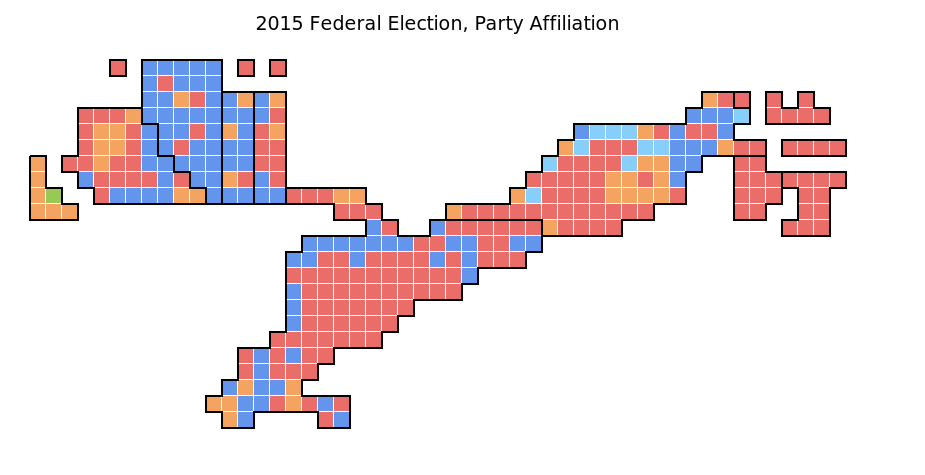

In [33]:
generalized_chorogrid("Party Affiliation", colors=list(ridings["Party: Color"]))

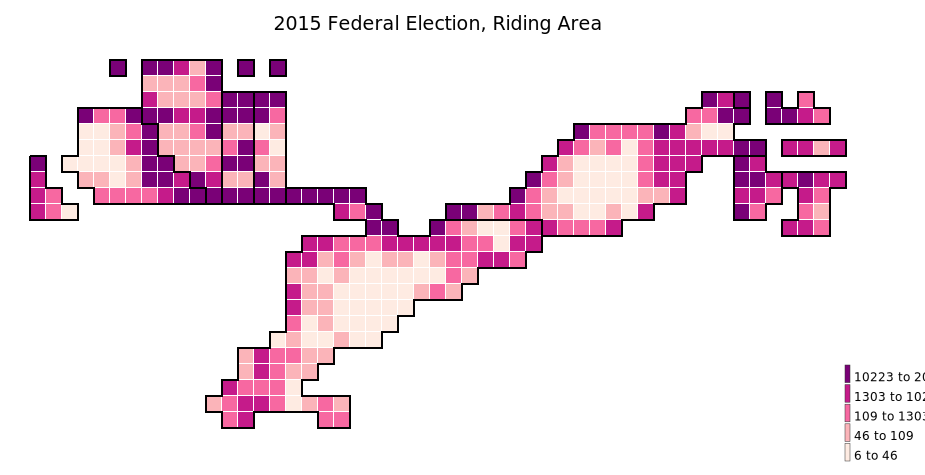

In [34]:
generalized_chorogrid("Riding Area", ridings["Area (km2)"])

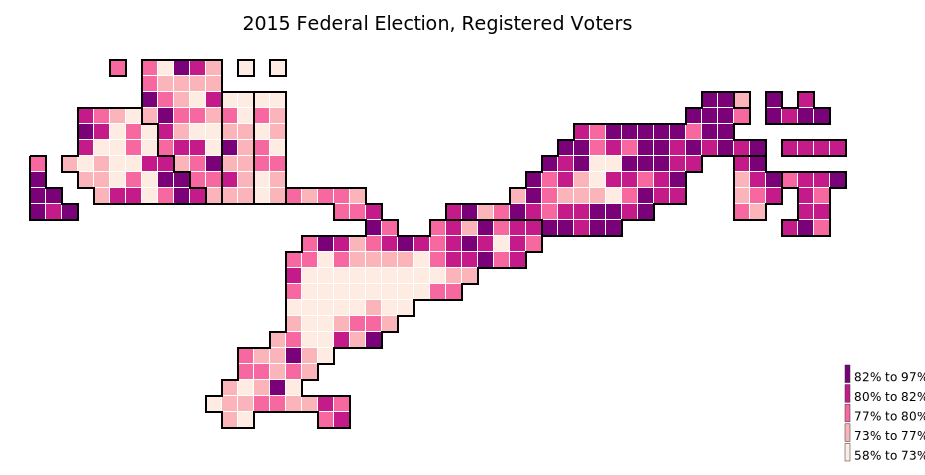

In [35]:
generalized_chorogrid("Registered Voters", ridings["Registered"] / ridings["Population"])

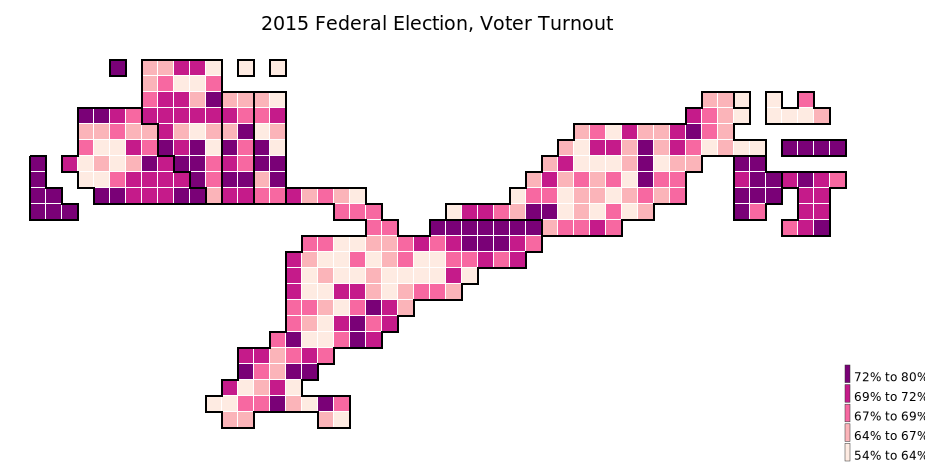

In [39]:
generalized_chorogrid("Voter Turnout", ridings["Ballots (Valid)"] / ridings["Registered"])

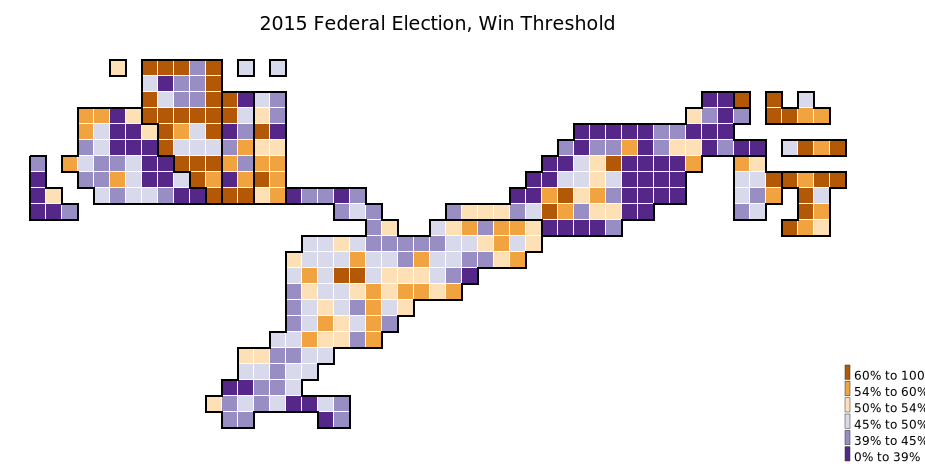

In [40]:
# Determine a good colouration of the chorogrid (3 colours below 50%, 3 above)
tertiles_low = ridings[ridings["Elected: Ballot %"] < 0.5]["Elected: Ballot %"].quantile([0/3, 1/3, 2/3, 3/3]).values
tertiles_high = ridings[ridings["Elected: Ballot %"] > 0.5]["Elected: Ballot %"].quantile([0/3, 1/3, 2/3, 3/3]).values
color_range = (
    ((0.0, tertiles_low[1]), '#542788'),
    ((tertiles_low[1], tertiles_low[2]), '#998ec3'),
    ((tertiles_low[2], 0.5), '#d8daeb'),
    ((0.5, tertiles_high[1]), '#fee0b6'),
    ((tertiles_high[1], tertiles_high[2]), '#f1a340'),
    ((tertiles_high[2], 1.0), '#b35806'),
)
range_key_dict = RangeKeyDict(dict(color_range))
canada_riding_colors = [range_key_dict[x] for x in list(ridings["Elected: Ballot %"])]

# Generate the per-riding choropleth
cg_ridings = Chorogrid('chorogrid/databases/canada_federal_ridings.csv', list(ridings.district_code), canada_riding_colors, 'district_code')
cg_ridings.set_title('2015 Federal Election, Win Threshold', font_dict={'font-size': 19})
cg_ridings.set_legend([c[1] for c in color_range], ["{}% to {}%".format(int(c[0][0] * 100), int(c[0][1] * 100)) for c in color_range], width=5)
render_chorogrid(cg_ridings)